<h1 align="center">Rainfall Predict with LSTM and LSTM Attention </h1>



In [1]:
!pip install -U scikit-learn

  Using cached scikit_learn-1.5.1-cp312-cp312-win_amd64.whl.metadata (12 kB)
Using cached scikit_learn-1.5.1-cp312-cp312-win_amd64.whl (10.9 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the library needed

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, Add, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import joblib

Read data

In [3]:
# Membaca data keseluruhan

#Skenario 1
# rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2019-2023.csv"

# Skenario 2
# rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2014-2024.csv"

# Skenario 3
rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2010-2024.csv"

df = pd.read_csv(rainfall_data_url, parse_dates=['Tanggal'], index_col='Tanggal')

print('Dataset : \n', df.head())
print('Dataset : \n', df.tail())
print('\n')

# Menghitung jumlah hari dalam dataset
days_count = len(df.index)
print("Jumlah hari dalam dataset:", days_count)

Dataset : 
               Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  ddd_x  ff_avg ddd_car
Tanggal                                                                    
01-01-2010  25.0  31.4  27.1    85.0  0.0  7.3   6.0   45.0     2.0      NE
02-01-2010  25.0  30.8  26.9    86.0  0.0  5.4   5.0   45.0     2.0      NE
03-01-2010  24.0  31.2  27.4    86.0  0.0  4.0   7.0   45.0     3.0      E 
04-01-2010  24.0  27.8  25.9    85.0  0.0  0.0   4.0  270.0     2.0      W 
05-01-2010  25.0  31.0  27.0    84.0  0.0  4.4   6.0   90.0     3.0      NE
Dataset : 
               Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg ddd_car
Tanggal                                                                     
27-05-2024  26.6  33.4  29.7    82.0   0.0  1.8   5.0  140.0     2.0      S 
28-05-2024  27.7  33.4  29.0    87.0   0.0  2.7   5.0  170.0     2.0      S 
29-05-2024  25.7  34.0  29.3    83.0  20.6  2.8   5.0  200.0     2.0      C 
30-05-2024  26.9  31.2  28.3    85.0  20.6  6.1   7.0  210.

Correlation matrix


 Correlation Matrix 



<Axes: >

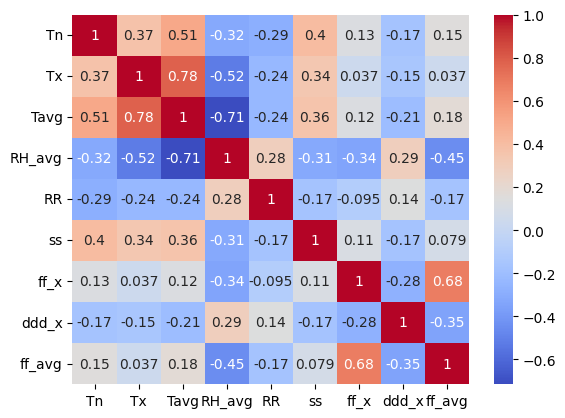

In [4]:
print("\n Correlation Matrix \n")

matrix = df.drop(columns=['ddd_car']).corr()
# matrix = df.corr()
#plotting correlation matrix
sns.heatmap(matrix, cmap="coolwarm", annot=True)


Split data to train, test, and validate

In [6]:
# Membagi data menjadi training, validation, dan testing sets

# Scenario 1 - 70:15:15
# train = df['01-01-2019':'28-02-2022']
# validation = df['01-03-2022':'28-02-2023']
# test = df['01-03-2023':'31-12-2023']

# Scenario 2 - 70:15:15
# train = df['01/01/2014':'15/04/2021']
# validation = df['16/04/2021':'06/11/2022']
# test = df['07/11/2022':'31/05/2024']

# Scenario 3 - 80:10:10
train = df['01-01-2010': '13-07-2021']
validation = df['14-07-2021' : '21-12-2022']
test = df['22-12-2022' : '31-05-2024']

# Displaying the number of records in each set
print(f'Training set: {train.shape[0]} records')
print(f'Validation set: {validation.shape[0]} records')
print(f'Test set: {test.shape[0]} records')

# Selecting features and target
features = ['Tavg', 'ff_avg', 'RH_avg', 'ss']
X_train = train[features]
y_train = train['RR']
X_val = validation[features]
y_val = validation['RR']
X_test = test[features]
y_test = test['RR']

Training set: 4212 records
Validation set: 526 records
Test set: 527 records


In [7]:
# Normalisasi data Fitur dan target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape y_train, y_val, y_test to (n_samples, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_val_reshaped = y_val.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Fit and transform on training set, transform on validation and test sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
y_val_scaled = scaler_y.transform(y_val_reshaped).flatten()
y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()

# Fungsi untuk membentuk data menjadi sequence
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Misalnya, gunakan 10 hari sebelumnya untuk memprediksi hari berikutnya
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Save the scalers
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

Data shape verification

In [8]:
# Verifikasi bentuk data
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_val_seq:", X_val_seq.shape)
print("Shape of y_val_seq:", y_val_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of X_train_seq: (4202, 10, 4)
Shape of y_train_seq: (4202,)
Shape of X_val_seq: (516, 10, 4)
Shape of y_val_seq: (516,)
Shape of X_test_seq: (517, 10, 4)
Shape of y_test_seq: (517,)


### Regular LSTM model build and training

In [14]:
# Membangun model LSTM biasa
def build_lstm_model(input_shape, units=128, learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Membangun model LSTM
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm = build_lstm_model(input_shape)

# Displaying model summary
model_lstm.summary()

history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM
y_pred_lstm = model_lstm.predict(X_test_seq)

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print(" \n ===================================================== \n")
print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM: {rmse_lstm}')
print(" \n ===================================================== \n")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,393 (1.26 MB)

 Trainable params: 331,393 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
132/132 - 10s - 79ms/step - loss: 0.0579 - val_loss: 0.0207
Epoch 2/100
132/132 - 3s - 22ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 3/100
132/132 - 3s - 24ms/step - loss: 0.0184 - val_loss: 0.0170
Epoch 4/100
132/132 - 3s - 19ms/step - loss: 0.0174 - val_loss: 0.0162
Epoch 5/100
132/132 - 3s - 20ms/step - loss: 0.0169 - val_loss: 0.0160
Epoch 6/100
132/132 - 3s - 19ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 7/100
132/132 - 3s - 20ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 8/100
132/132 - 2s - 19ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 9/100
132/132 - 2s - 19ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 10/100
132/132 - 2s - 19ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 11/100
132/132 - 3s - 19ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 12/100
132/132 - 3s - 19ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 13/100
132/132 - 3s - 20ms/step - loss: 0.0156 - val_loss: 0.0172
Epoch 14/100
132/132 - 3s - 19ms/step - loss: 0.0157 - val_loss: 0.0163


### LSTM Attention Mechanism model build and training

In [15]:
def build_lstm_attention_model(input_shape, lstm_units=128, learning_rate=0.01):
    inputs = Input(shape=input_shape)

    # Adding multiple LSTM layers sequentially
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_out = LSTM(lstm_units, return_sequences=True)(lstm_out)
    lstm_out = LSTM(lstm_units, return_sequences=True)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])
    context_vector = Add()([lstm_out, attention])

    # Global average pooling to reduce the dimensionality
    context_vector = GlobalAveragePooling1D()(context_vector)
    
    # Output Layer
    outputs = Dense(1)(context_vector)

    # Model compilation
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Membangun model LSTM dengan Attention Mechanism
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm_attention = build_lstm_attention_model(input_shape)

# Displaying model summary
model_lstm_attention.summary()

history_lstm_attention = model_lstm_attention.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32 ,verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM dengan Attention Mechanism
y_pred_lstm_attention = model_lstm_attention.predict(X_test_seq)

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

mse_lstm_attention = mean_squared_error(y_test_seq, y_pred_lstm_attention)
mae_lstm_attention = mean_absolute_error(y_test_seq, y_pred_lstm_attention)
rmse_lstm_attention = root_mean_squared_error(y_test_seq, y_pred_lstm_attention)
r2_lstm_attention = r2_score(y_test_seq, y_pred_lstm_attention)

print(" \n ===================================================== \n")
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')
print(" \n ===================================================== \n")

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 10, 128)   │     68,096 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 10, 128)   │    131,584 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 10, 128)   │    131,584 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 10, 128)   │          0 │ lstm_11[0][0],    │
│ (Attention)         │                   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 128)   │          0 │ lstm_11[0][0],    │
│                     │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 331,393 (1.26 MB)

 Trainable params: 331,393 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
132/132 - 9s - 69ms/step - loss: 0.0394 - val_loss: 0.0189
Epoch 2/100
132/132 - 3s - 23ms/step - loss: 0.0196 - val_loss: 0.0227
Epoch 3/100
132/132 - 5s - 40ms/step - loss: 0.0185 - val_loss: 0.0176
Epoch 4/100
132/132 - 3s - 24ms/step - loss: 0.0173 - val_loss: 0.0208
Epoch 5/100
132/132 - 3s - 23ms/step - loss: 0.0183 - val_loss: 0.0205
Epoch 6/100
132/132 - 3s - 23ms/step - loss: 0.0169 - val_loss: 0.0172
Epoch 7/100
132/132 - 3s - 24ms/step - loss: 0.0165 - val_loss: 0.0193
Epoch 8/100
132/132 - 3s - 24ms/step - loss: 0.0168 - val_loss: 0.0162
Epoch 9/100
132/132 - 3s - 26ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 10/100
132/132 - 4s - 29ms/step - loss: 0.0160 - val_loss: 0.0178
Epoch 11/100


Result and evaluation

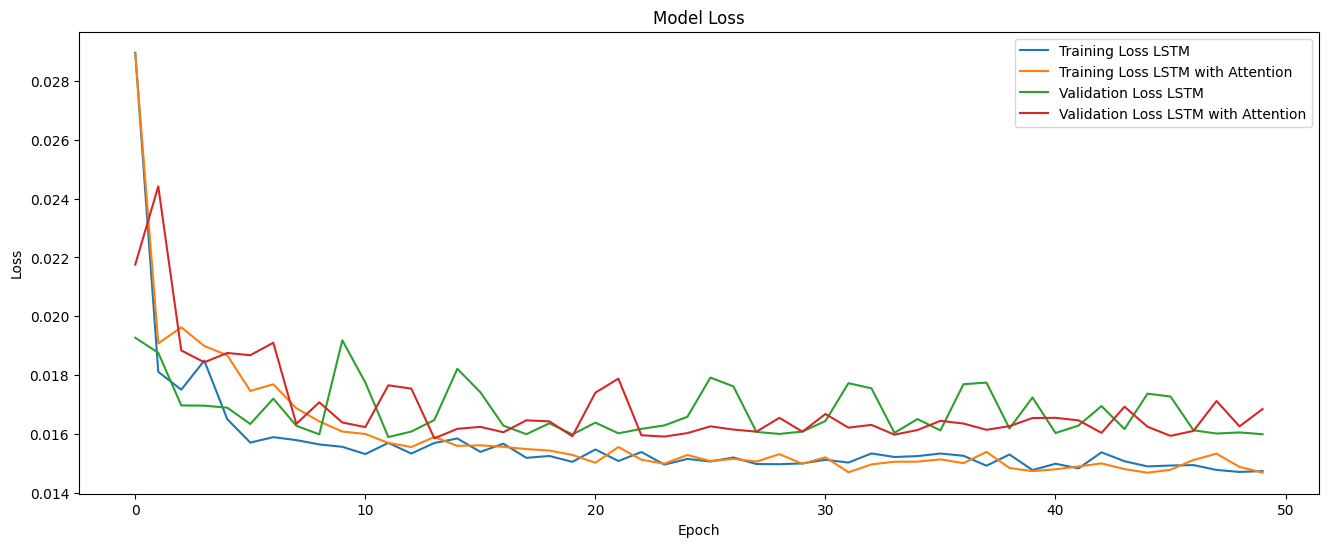

R-squared LSTM: [0.37306458]
MSE LSTM: [0.01801627]
MAE LSTM: [0.10562809]
RMSE LSTM : [0.1342247]
R-squared LSTM with Attention: [0.37600666]
MSE LSTM with Attention: [0.01793172]
MAE LSTM with Attention: [0.10069232]
RMSE LSTM with Attention: [0.13390939]


In [11]:
# Plot hasil pelatihan
plt.figure(figsize=(16, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm_attention.history['loss'], label='Training Loss LSTM with Attention')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
plt.plot(history_lstm_attention.history['val_loss'], label='Validation Loss LSTM with Attention')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menampilkan hasil evaluasi
print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM : {rmse_lstm}')
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')


Nilai prediksi dan nilai asli LSTM Regular

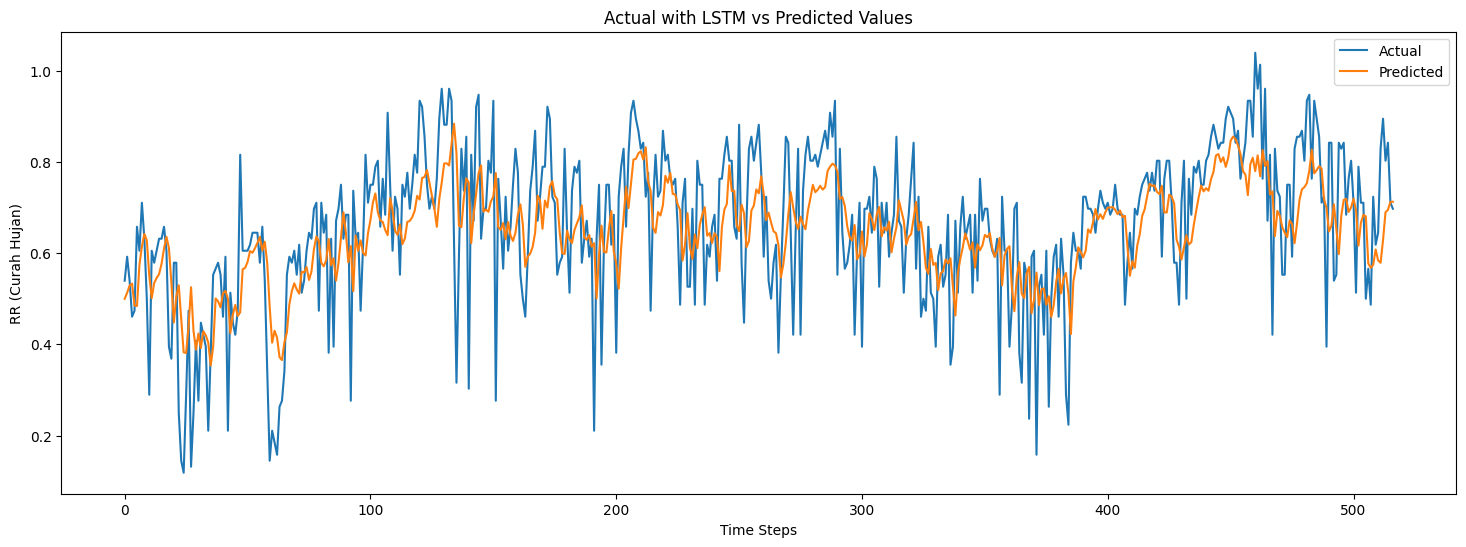

In [12]:
# Plot prediksi vs nilai sebenarnya LSTM Reguler
plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('Actual with LSTM vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Nilai prediksi dan nilai asli LSTM Attention

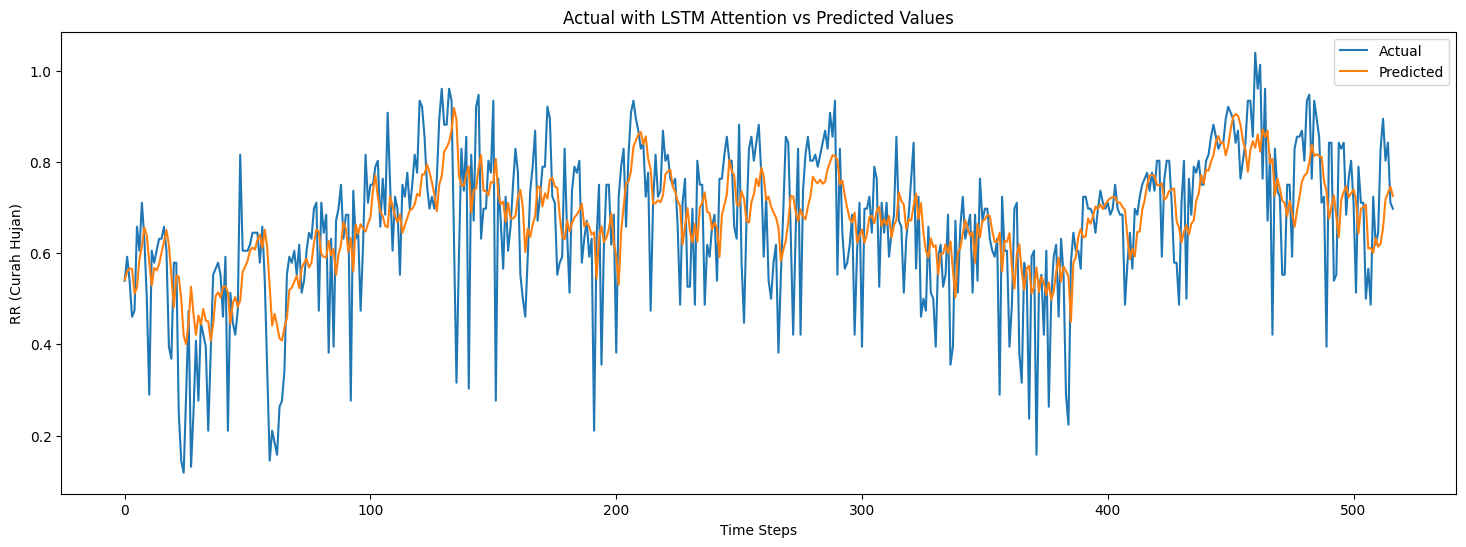

In [13]:
# Plot prediksi vs nilai sebenarnya LSTM Attention

# Mengembalikan ke nilai asli
plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm_attention, label='Predicted')
plt.title('Actual with LSTM Attention vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Save the model

In [44]:
# Simpan model
tf.saved_model.save(model_lstm, 'saved_model_lstm')
tf.saved_model.save(model_lstm_attention, 'saved_model_lstm_attention')

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [ ]:
# Zip model agar mudah di download
!zip -r /content/saved_model_lstm.zip /content/saved_model_lstm
!zip -r /content/saved_model_lstm_attention.zip /content/saved_model_lstm_attention

  adding: content/saved_model_lstm/ (stored 0%)
  adding: content/saved_model_lstm/variables/ (stored 0%)
  adding: content/saved_model_lstm/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model_lstm/variables/variables.index (deflated 64%)
  adding: content/saved_model_lstm/saved_model.pb (deflated 90%)
  adding: content/saved_model_lstm/assets/ (stored 0%)
  adding: content/saved_model_lstm/fingerprint.pb (stored 0%)
  adding: content/saved_model_lstm_attention/ (stored 0%)
  adding: content/saved_model_lstm_attention/variables/ (stored 0%)
  adding: content/saved_model_lstm_attention/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model_lstm_attention/variables/variables.index (deflated 62%)
  adding: content/saved_model_lstm_attention/saved_model.pb (deflated 90%)
  adding: content/saved_model_lstm_attention/assets/ (stored 0%)
  adding: content/saved_model_lstm_attention/fingerprint.pb (stored 0%)
